# Analyse de Drift en Production

Ce notebook analyse les prédictions de production de l'API de scoring crédit pour détecter :
- Le **data drift** (dérive des features d'entrée) via Evidently AI
- Le **prediction drift** (dérive des sorties du modèle)

In [17]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from evidently.presets import DataDriftPreset
from evidently import Report
from sqlalchemy import create_engine
from pathlib import Path
load_dotenv()

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 15)

engine = create_engine(os.environ["DATABASE_URL"])

In [18]:
# Load reference data (training distribution)
FEATURE_COLUMNS = [
    "EXT_SOURCES_MEAN", "CREDIT_TERM", "EXT_SOURCE_3",
    "GOODS_PRICE_CREDIT_PERCENT", "INSTAL_AMT_PAYMENT_sum",
    "AMT_ANNUITY", "POS_CNT_INSTALMENT_FUTURE_mean",
    "DAYS_BIRTH", "EXT_SOURCES_WEIGHTED", "EXT_SOURCE_2",
]

ref_data = pd.read_sql("SELECT * FROM reference_data", engine)
ref_features = ref_data[FEATURE_COLUMNS]

print(f"Reference data: {ref_features.shape[0]:,} rows, {ref_features.shape[1]} features")
ref_features.describe()

Reference data: 307,511 rows, 10 features


EXT_SOURCES_MEAN    CREDIT_TERM   EXT_SOURCE_3  \
count     307511.000000  307511.000000  307511.000000   
mean           0.509260       0.053695       0.515695   
std            0.149761       0.022481       0.174736   
min            0.000006       0.022073       0.000527   
25%            0.413716       0.036900       0.417100   
50%            0.524502       0.050000       0.535276   
75%            0.622757       0.064043       0.636376   
max            0.878903       0.124430       0.896010   

       GOODS_PRICE_CREDIT_PERCENT  INSTAL_AMT_PAYMENT_sum    AMT_ANNUITY  \
count               307511.000000            3.075110e+05  307511.000000   
mean                     0.900683            6.600106e+05   27108.487841   
std                      0.096587            8.957638e+05   14493.461065   
min                      0.166667            0.000000e+00    1615.500000   
25%                      0.834725            1.376142e+05   16524.000000   
50%                      0.893815            3.186195e+05   24903.000000   
75%                      1.000000            7.865052e+05   34596.000000   
max                      6.666667            2.553705e+07  258025.500000   

       POS_CNT_INSTALMENT_FUTURE_mean     DAYS_BIRTH  EXT_SOURCES_WEIGHTED  \
count                   307511.000000  307511.000000         307511.000000   
mean                         9.047393  -16036.995067              1.636083   
std                          6.359185    4363.988632              2.308806   
min                          0.000000  -25229.000000              0.000000   
25%                          5.052632  -19682.000000              0.000000   
50%                          6.950000  -15750.000000              0.000000   
75%                         11.264706  -12413.000000              3.991048   
max                         60.000000   -7489.000000              7.677298   

       EXT_SOURCE_2  
count  3.075110e+05  
mean   5.145034e-01  
std    1.908699e-01  
min    8.173617e-08  
25%    3.929737e-01  
50%    5.659614e-01  
75%    6.634218e-01  
max    8.549997e-01

In [19]:
# Load production logs from PostgreSQL
prod_df = pd.read_sql("SELECT * FROM predictions ORDER BY timestamp", engine)
prod_df["timestamp"] = pd.to_datetime(prod_df["timestamp"])

print(f"Total predictions: {len(prod_df)}")
print(f"Period: {prod_df['timestamp'].min()} to {prod_df['timestamp'].max()}")

# Extract features
prod_features = pd.DataFrame(prod_df["input_features"].tolist())
prod_features = prod_features[FEATURE_COLUMNS]

print(f"Features extracted: {len(prod_features):,} rows")
prod_features.describe()

Total predictions: 1000
Period: 2026-02-06 14:50:10.777571+00:00 to 2026-02-13 14:28:43.562355+00:00
Features extracted: 1,000 rows


EXT_SOURCES_MEAN  CREDIT_TERM  EXT_SOURCE_3  \
count       1000.000000  1000.000000   1000.000000   
mean           0.512405     0.052946      0.522156   
std            0.154804     0.021638      0.168035   
min            0.003038     0.025278      0.000527   
25%            0.411188     0.037536      0.434290   
50%            0.525387     0.050000      0.535276   
75%            0.629354     0.057946      0.634706   
max            0.853731     0.120457      0.881027   

       GOODS_PRICE_CREDIT_PERCENT  INSTAL_AMT_PAYMENT_sum    AMT_ANNUITY  \
count                 1000.000000            1.000000e+03    1000.000000   
mean                     0.901852            7.106146e+05   31342.161600   
std                      0.096388            9.801195e+05   15964.258568   
min                      0.654450            4.497345e+03    5092.200000   
25%                      0.834725            1.438499e+05   19531.800000   
50%                      0.893815            3.321744e+05   28625.400000   
75%                      1.000000            8.863601e+05   40224.600000   
max                      1.800000            9.055123e+06  122364.000000   

       POS_CNT_INSTALMENT_FUTURE_mean    DAYS_BIRTH  EXT_SOURCES_WEIGHTED  \
count                     1000.000000   1000.000000           1000.000000   
mean                         9.200616 -13135.734000              1.435957   
std                          6.772972   4438.966544              2.244636   
min                          0.000000 -21992.000000              0.000000   
25%                          5.000000 -16795.250000              0.000000   
50%                          6.950000 -12892.500000              0.000000   
75%                         11.407759  -9557.500000              3.482888   
max                         45.055556  -4701.000000              7.068308   

       EXT_SOURCE_2  
count   1000.000000  
mean       0.371158  
std        0.181753  
min        0.000000  
25%        0.256775  
50%        0.420851  
75%        0.513682  
max        0.659881

In [20]:
# Evidently Data Drift Report
drift_report = Report(metrics=[DataDriftPreset()])
drift_snapshot = drift_report.run(reference_data=ref_features, current_data=prod_features)
drift_snapshot

In [21]:
# Save drift report as HTML
report_path = Path("data_drift_report.html")
drift_snapshot.save_html(str(report_path))
print(f"Drift report saved to {report_path.resolve()}")

Drift report saved to /Users/dimitrihertz/Desktop/dev/open_classroom/project_8/monitoring/data_drift_report.html


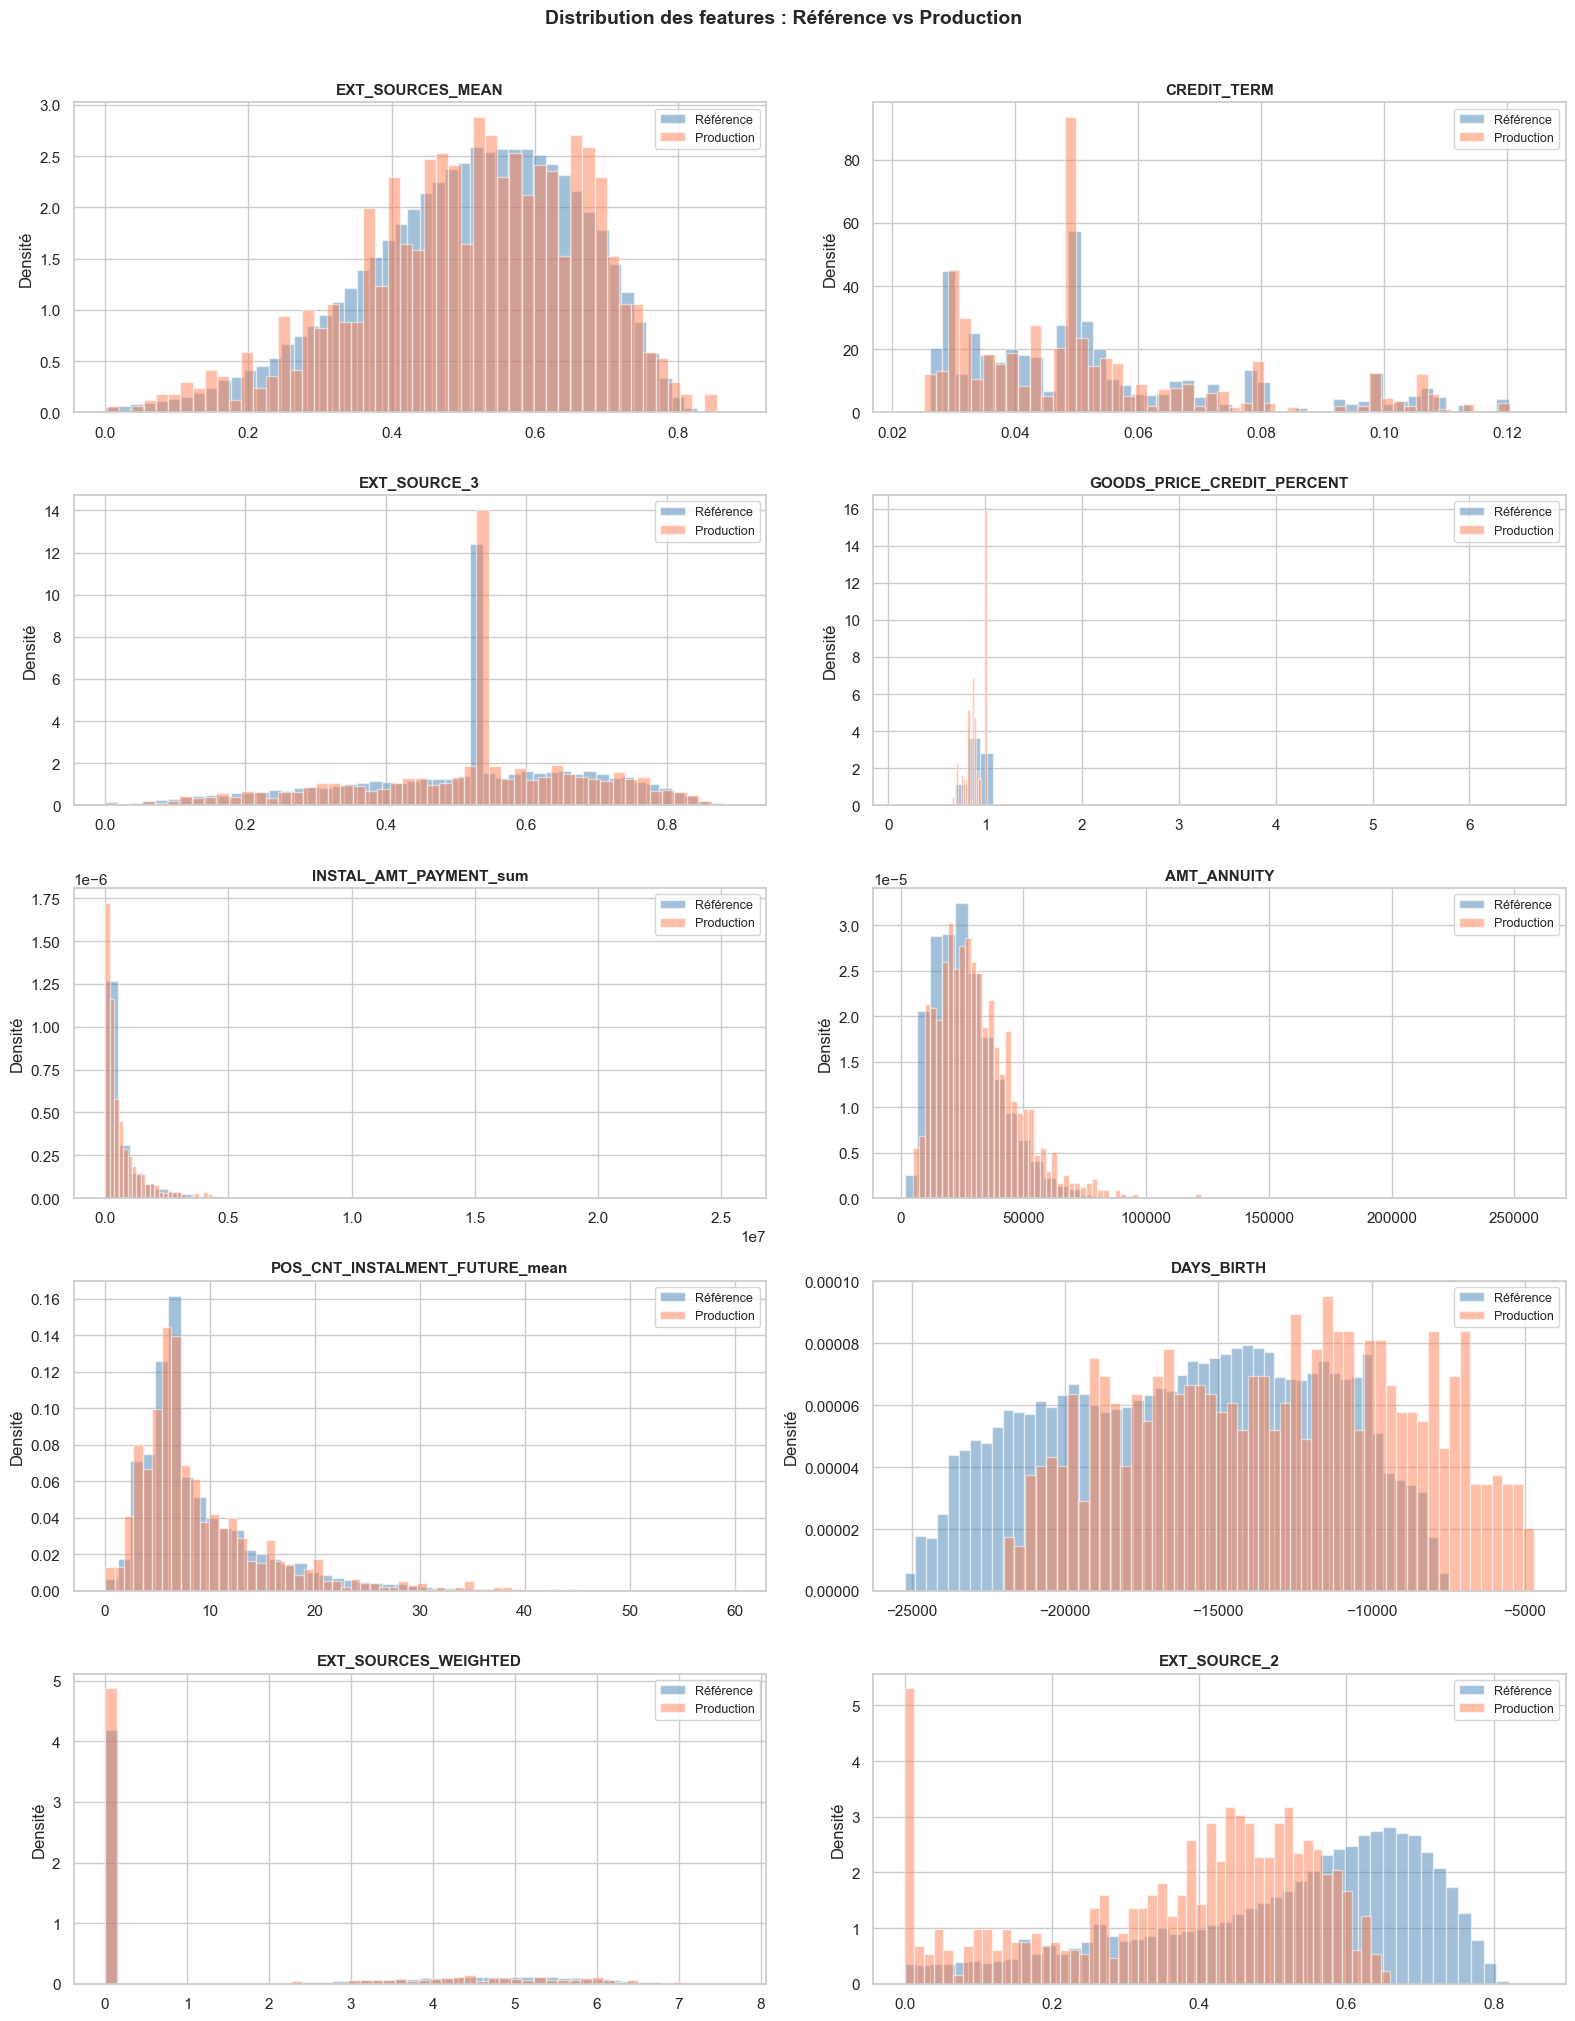

In [22]:
# Distribution comparison: Reference vs Production
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(FEATURE_COLUMNS):
    ax = axes[i]
    ax.hist(ref_features[col].dropna(), bins=50, alpha=0.5, label="Référence", density=True, color="steelblue")
    ax.hist(prod_features[col].dropna(), bins=50, alpha=0.5, label="Production", density=True, color="coral")
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.legend(fontsize=9)
    ax.set_ylabel("Densité")

fig.suptitle("Distribution des features : Référence vs Production", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

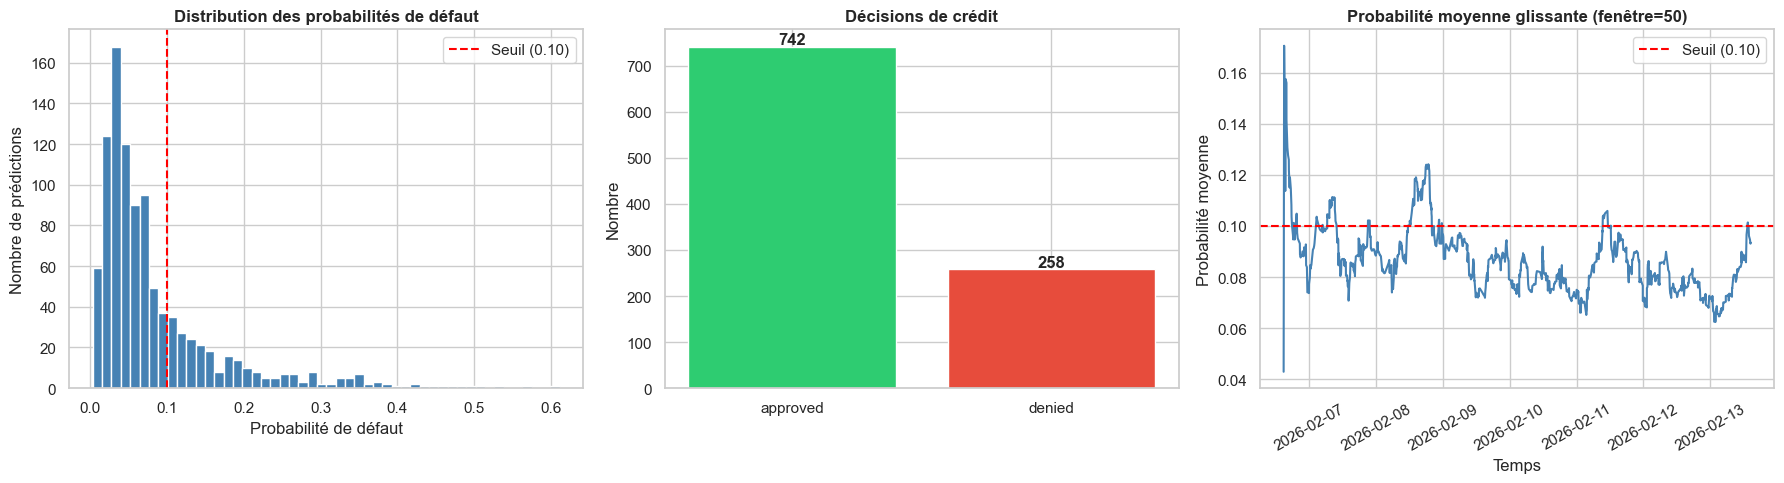

In [23]:
# Prediction drift analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Probability distribution
axes[0].hist(prod_df["probability_default"], bins=50, color="steelblue", edgecolor="white")
axes[0].axvline(x=0.10, color="red", linestyle="--", label="Seuil (0.10)")
axes[0].set_title("Distribution des probabilités de défaut", fontweight="bold")
axes[0].set_xlabel("Probabilité de défaut")
axes[0].set_ylabel("Nombre de prédictions")
axes[0].legend()

# Decision counts
decision_counts = prod_df["credit_decision"].value_counts()
colors = ["#2ecc71" if d == "approved" else "#e74c3c" for d in decision_counts.index]
axes[1].bar(decision_counts.index, decision_counts.values, color=colors)
axes[1].set_title("Décisions de crédit", fontweight="bold")
axes[1].set_ylabel("Nombre")
for j, v in enumerate(decision_counts.values):
    axes[1].text(j, v + 5, str(v), ha="center", fontweight="bold")

# Rolling average of probability over time
ts_sorted = prod_df.sort_values("timestamp").reset_index(drop=True)
ts_sorted["prob_rolling"] = ts_sorted["probability_default"].rolling(window=50, min_periods=1).mean()
axes[2].plot(ts_sorted["timestamp"], ts_sorted["prob_rolling"], color="steelblue", linewidth=1.5)
axes[2].axhline(y=0.10, color="red", linestyle="--", label="Seuil (0.10)")
axes[2].set_title("Probabilité moyenne glissante (fenêtre=50)", fontweight="bold")
axes[2].set_xlabel("Temps")
axes[2].set_ylabel("Probabilité moyenne")
axes[2].legend()
axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

In [24]:
# Summary statistics
total = len(prod_df)
denied = (prod_df["credit_decision"] == "denied").sum()

print("=" * 50)
print("  TABLEAU DE BORD - MÉTRIQUES DE PRÉDICTION")
print("=" * 50)
print(f"  Prédictions totales :    {total:,}")
print(f"  Crédits refusés :        {denied:,}/{total:,} ({denied/total:.1%})")
print("=" * 50)

  TABLEAU DE BORD - MÉTRIQUES DE PRÉDICTION
  Prédictions totales :    1,000
  Crédits refusés :        258/1,000 (25.8%)


## Recommandations

### Points de vigilance - Drift détecté

L'analyse Evidently révèle un drift significatif sur **3 features** :

| Feature | Type de drift | Cause probable | Impact |
|---------|--------------|----------------|--------|
| `EXT_SOURCE_2` | Shift vers le bas (-0.15) | Changement de scoring du bureau de crédit | Augmentation des scores de risque |
| `DAYS_BIRTH` | Shift vers 0 (+3000 jours) | Rajeunissement de la clientèle | Profil de risque différent |
| `AMT_ANNUITY` | Augmentation (+20%) | Inflation / hausse des montants | Surestimation possible du risque |

